# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT TP. HCM
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU
<br/>

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY DỰ ĐOÁN GIÁ NÔNG SẢN

<br/>

<p>Họ và tên Sinh viên 1 : Huỳnh Hạo Nhị MSSV 1: 20133006 <p>
<br/>
Họ và tên Sinh viên 2 : Võ Hoài Thương MSSV 2: 20133012

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV

from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# Dữ liệu

In [2]:
RICE_QUANTITY_URI = "https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Cam/gia_cam_thoi_tiet.csv"

In [3]:
var_file_name = 'arimax_gia_lua_xang.joblib'
varma_file_name = 'arimax_gia_lua_xang.joblib'


In [4]:
df = pd.read_csv(RICE_QUANTITY_URI)

In [5]:
df.set_index('date', inplace=True)

In [6]:
df.head()

,price,tavg,tmin,tmax,prcp,wdir,wspd,pres
date,,,,,,,,
2007-07-17,16000.0,82.8,75.6,92.5,1.650,247.0,5.2,1011.0
2007-07-19,16000.0,80.6,77.4,92.8,1.650,247.0,5.4,1011.0
2007-07-20,16000.0,83.5,77.4,92.8,4.291,247.0,5.4,1011.0
2007-07-23,16000.0,82.9,77.0,91.4,4.291,247.0,5.2,1011.0
2007-07-24,16000.0,81.0,75.2,93.6,4.291,247.0,5.2,1011.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2478 entries, 2007-07-17 to 2024-03-12
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2478 non-null   float64
 1   tavg    2478 non-null   float64
 2   tmin    2478 non-null   float64
 3   tmax    2478 non-null   float64
 4   prcp    2476 non-null   float64
 5   wdir    2478 non-null   float64
 6   wspd    2478 non-null   float64
 7   pres    2478 non-null   float64
dtypes: float64(8)
memory usage: 174.2+ KB


<Axes: >

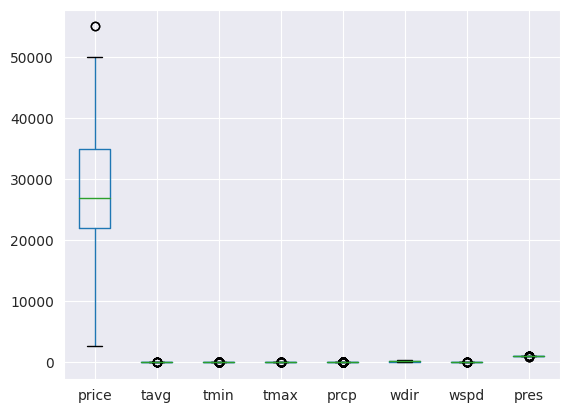

In [8]:
df.boxplot()

In [9]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df.at[df.index[0], 'price'] = min(max(df.iloc[0]['price'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df.index[previous_date_index]
        previous_value = df.loc[previous_date, 'price']
        df.at[index, 'price'] = previous_value

Số lượng outlier: 2


<Axes: >

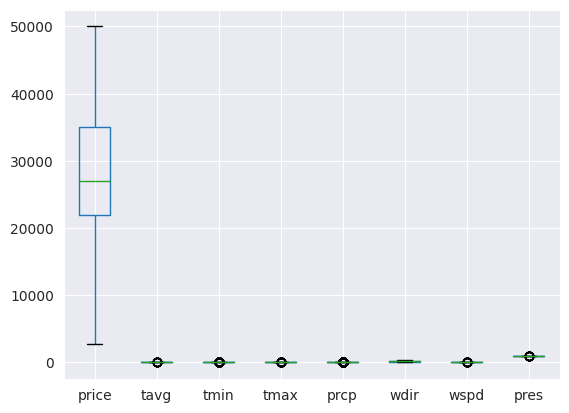

In [10]:
df.boxplot()

In [11]:
df = df.dropna()

In [12]:
df_corr = df.copy()
df_corr.tavg = df_corr.tavg.shift(-30)
df_corr.pres = df_corr.pres.shift(60)



In [13]:
# Find the pearson correlations matrix
corr = df_corr.corr(method = 'pearson')
corr

,price,tavg,tmin,tmax,prcp,wdir,wspd,pres
price,1.000000,0.092178,0.177502,0.048452,-0.142541,0.055731,0.073485,0.044222
tavg,0.092178,1.000000,0.092028,0.154252,-0.119542,-0.194624,0.083855,-0.153553
tmin,0.177502,0.092028,1.000000,0.467295,-0.214667,0.152874,0.299633,-0.044664
tmax,0.048452,0.154252,0.467295,1.000000,-0.051549,-0.089167,0.166784,0.091573
prcp,-0.142541,-0.119542,-0.214667,-0.051549,1.000000,-0.052588,-0.074783,0.110494
wdir,0.055731,-0.194624,0.152874,-0.089167,-0.052588,1.000000,0.115077,0.025946
wspd,0.073485,0.083855,0.299633,0.166784,-0.074783,0.115077,1.000000,0.084811
pres,0.044222,-0.153553,-0.044664,0.091573,0.110494,0.025946,0.084811,1.000000


In [14]:
fillter_feature = ['price', 'tavg', 'pres',  'prcp']
df = df[fillter_feature]

In [15]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,tavg,pres,prcp
price,1.000000,0.151000,-0.070885,-0.142541
tavg,0.151000,1.000000,-0.163334,-0.201611
pres,-0.070885,-0.163334,1.000000,0.096124
prcp,-0.142541,-0.201611,0.096124,1.000000


<Axes: xlabel='date'>

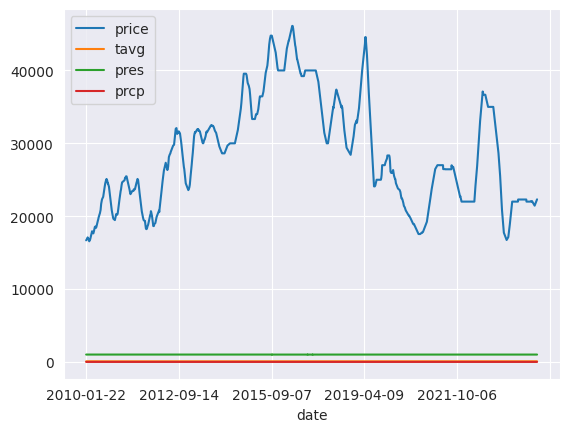

In [16]:
df.price = df.price.rolling(45).mean()
df = df.dropna()
df.plot()

In [17]:
nobs = int(len(df) * 0.8)
df_train, df_test = df[0:nobs], df[nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(1945, 4)
(487, 4)


In [18]:
from google.colab import files


## Kiểm tra stationary

In [19]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [20]:
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9212
 No. Lags Chosen       = 2
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0429. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "tavg" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.9286
 No. Lags Chosen       = 9
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pres" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0

In [21]:
# df_differenced = np.log(df_train)
# df_differenced = df_differenced.dropna()
# df_differenced = df_differenced[1:]

In [22]:
df_differenced = df_train.diff().dropna()

In [23]:
df_differenced

,price,tavg,pres,prcp
date,,,,
2010-01-25,44.444444,-0.2,0.0,0.0
2010-01-26,44.444444,-1.4,0.0,0.0
2010-01-27,44.444444,1.8,0.0,0.0
2010-01-28,22.222222,-0.2,0.0,0.0
2010-01-29,22.222222,0.7,0.0,0.0
...,...,...,...,...
2021-07-08,0.000000,-0.8,0.5,0.0
2021-07-09,0.000000,1.5,-0.4,0.0
2021-07-12,0.000000,2.1,1.3,0.0


In [24]:
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.1143
 No. Lags Chosen       = 1
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "tavg" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.5437
 No. Lags Chosen       = 21
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pres" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.

<Axes: xlabel='date'>

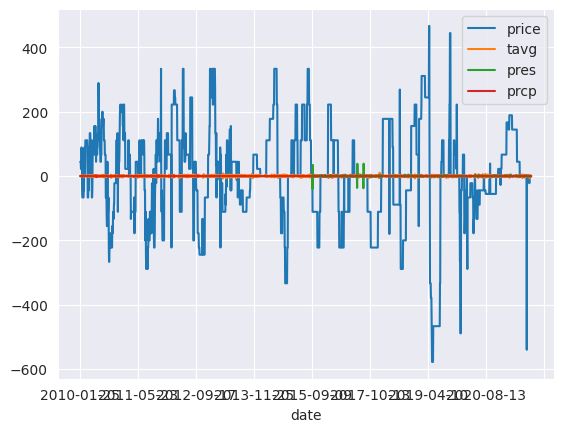

In [25]:
df_differenced.plot()

## Train model

Chúng tôi sử dụng phương pháp điều chỉnh tham số bằng cách lặp qua các bộ tham số tương tứng (p, d, q) cho ARIMA, kết hợp biến ngoại sinh (exogenous) cho mô hình ARIMAX, (p) cho mô hình VAR và (p, q) cho mô hình VARMA.  

Chọn tham số (p, q) cho mô hình VARMA còn là sự kết hợp với mô hình ARIMA để tìm được bộ tham số tốt nhất cho tập dữ liệu giá. Sau đó áp dụng vào mô hình với dữ liệu đa biến để tăng tốc độ và đảm bảo mô hình có độ chính xác cao.  

Việc chọn tham số cần kết hợp với các đồ thị tự tương quan ACF và PACF để chọn đầu vào tối ưu. 

In [26]:
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_absolute_percentage_error
def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast) * 100 # MAPE

    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    return({'mape':mape,'rmse':rmse})

In [27]:
columns_train = fillter_feature

In [28]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.5 MB/s eta 0:00:00


In [29]:
from pmdarima import auto_arima

In [30]:
arimax = auto_arima(df_differenced.price, exogenous = df_differenced[[ 'tavg', 'pres',  'prcp']],
           start_p=3,
           start_q=3,
           max_p=7,
           max_q=7,
                    n_jobs=10,
                    d=1,
            max_order=20,
            seasonal=False,
          trace=True,error_action='ignore',suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=21162.043, Time=8.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21209.683, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21157.769, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21153.509, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21207.683, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21154.575, Time=2.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=21154.574, Time=1.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=21156.569, Time=3.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=21151.510, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=21152.576, Time=0.92 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=21152.573, Time=0.65 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=21155.769, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=21154.569, Time=1.16 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 19.714 seconds


In [31]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[str(col)+'_forecast'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [32]:
# Forecast
n_periods = len(df_test)
fitted, confint = arimax.predict(n_periods=n_periods,
                                  exogenous=[ 'tavg', 'pres',  'prcp'],
                                  return_conf_int=True)


In [33]:
np.square(fitted)

1944    3.469106e-10
1945    3.469106e-10
1946    3.469106e-10
1947    3.469106e-10
1948    3.469106e-10
            ...     
2426    3.469106e-10
2427    3.469106e-10
2428    3.469106e-10
2429    3.469106e-10
2430    3.469106e-10
Length: 487, dtype: float64

In [34]:
df_test.index

Index(['2021-07-15', '2021-07-16', '2021-07-19', '2021-07-22', '2021-07-23',
       '2021-07-26', '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
       ...
       '2024-01-23', '2024-01-24', '2024-02-19', '2024-02-20', '2024-02-26',
       '2024-02-28', '2024-02-29', '2024-03-04', '2024-03-05', '2024-03-06'],
      dtype='object', name='date', length=487)

In [35]:
fc_series = pd.DataFrame({'price': fitted.values}, index = df_test.index)

In [36]:
fc_series

,price
date,
2021-07-15,-0.000019
2021-07-16,-0.000019
2021-07-19,-0.000019
2021-07-22,-0.000019
2021-07-23,-0.000019
...,...
2024-02-28,-0.000019
2024-02-29,-0.000019
2024-03-04,-0.000019


<Axes: xlabel='date'>

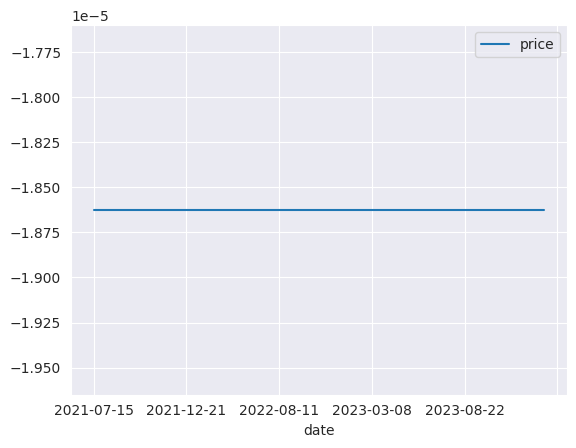

In [37]:
fc_series.plot()

In [38]:
fc_series.price = df_test.price.iloc[0] + fc_series.price.cumsum()

Đánh giá mô hình

In [40]:
accuracy_prod = forecast_accuracy(fc_series['price'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

mape :  19.9378
rmse :  5594.2547


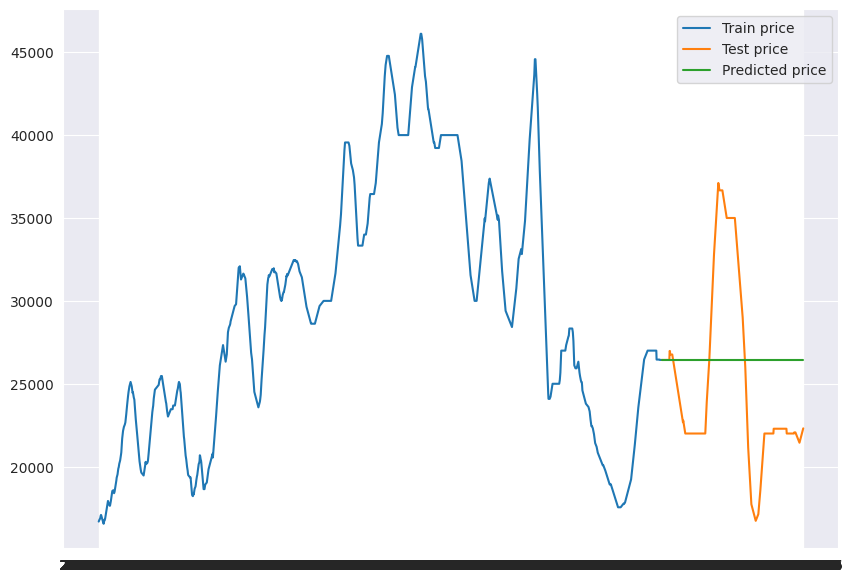

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['price']:

    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(df_train[str(i)], label='Train '+str(i))
    plt.plot(df_test[str(i)], label='Test '+str(i))
    plt.plot(fc_series[str(i)], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

In [42]:
import joblib
joblib.dump(arimax, varma_file_name)
from google.colab import files
files.download(varma_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
import joblib
from google.colab import drive

file_name = "arimax_gia_cam__thoi_tiet.joblib"
drive.mount('/content/drive')

joblib.dump(arimax, '/content/drive/MyDrive/model/' + file_name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/model/arimax_gia_cam__thoi_tiet.joblib']